# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [3]:
## Importing important libraries.
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

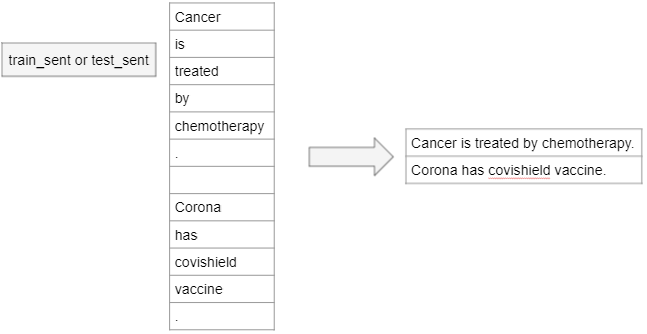

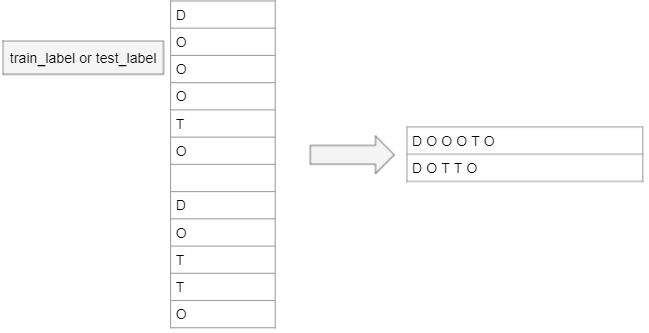

In [7]:
## Importing train test text and label data
with open('train_sent', 'r') as train_sent_file:
  train_sent = train_sent_file.readlines()
    
with open('test_sent') as test_sent_file:
    test_sent = test_sent_file.readlines()

with open('train_label', 'r') as train_label_file:
  train_label = train_label_file.readlines()
    
with open('test_label') as test_label_file:
    test_label = test_label_file.readlines()

In [8]:
# Checking 10 values of tran sentence and label.
train_sent[:10], train_label[:10]

(['All\n',
  'live\n',
  'births\n',
  '>\n',
  'or\n',
  '=\n',
  '23\n',
  'weeks\n',
  'at\n',
  'the\n'],
 ['O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n'])

In [9]:
# We can see words have \n at end of them, creating a function to remove it from end of words.
def strip_sentences(list):
    new = []
    for word in list:
        new.append(word.strip())
    return new

In [10]:
## Applying function to sentences and lables.
train_sent = strip_sentences(train_sent)
train_label = strip_sentences(train_label)
test_sent = strip_sentences(test_sent)
test_label = strip_sentences(test_label)

In [11]:
## Checking the words and lables now.
train_sent[:10], test_label[:10]

(['All', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [12]:
## Creating a function to create sentences from words
def Sentence_making(input_list):
    output_list = []
    sentence = ""

    for word in input_list:
        if word == "":
            if sentence:
                output_list.append(sentence.strip())
                sentence = ""
        else:
            sentence += word + " "

    if sentence:
        output_list.append(sentence.strip())

    return output_list

In [13]:
## Applying function to sentencees and lables.
train_sent_processed = Sentence_making(train_sent)
test_sent_processed = Sentence_making(test_sent)
train_label_processed = Sentence_making(train_label)
test_label_processed = Sentence_making(test_label)

In [14]:
## Printing 5 sentences and their lables.
for i in train_sent_processed[:5]:
    print(i)
    print("Label:-")
    for j in train_label_processed[:5]:
        print(j)
        print("")
        break

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label:-
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label:-
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label:-
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label:-
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Arrest 

### Count the number of sentences in the processed train and test dataset 

In [16]:
## Checking number of sentences in train and test sentences.
print('Total number of sentences in train set : {}'.format(len(train_sent_processed)))
print('Total number of sentences in test set : {}'.format(len(test_sent_processed)))

Total number of sentences in train set : 2599
Total number of sentences in test set : 1056


### Count the number of lines of labels in the processed train and test dataset.

In [18]:
## Checking number of sentences in train and test labels.
print('Total number of labeled sentences in train set : {}'.format(len(train_label_processed)))
print('Total number of labeled sentences in test set : {}'.format(len(test_label_processed)))

Total number of labeled sentences in train set : 2599
Total number of labeled sentences in test set : 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [21]:
## Creating a new list which is collection of train and test sentences.
combined_sent = train_sent_processed+test_sent_processed
len(combined_sent)

3655

In [22]:
## Importing libraries to tokenize, remove stop words and check frequency distribution
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

In [23]:
## Extracting Noun and pronoun from sentences after passing it through spacy model and changing it to lower case.
all_concepts = []

for sent_str in combined_sent:
    doc = model(sent_str)
    concepts = []
    for sent in doc.sents:
        for word in sent:
            if word.pos_ in ['NOUN', 'PROPN']:
                concepts.append(word.text.lower())
    all_concepts.extend(concepts)

In [24]:
## We got a list earlier, converting it into form of whole sentence.
all_concepts = " ".join(all_concepts)

In [25]:
## Tokenizing the words
tokenized_concepts = word_tokenize(all_concepts)

In [26]:
## Removing stop words
cleaned_concepts = []
for i in tokenized_concepts:
    if i not in stopwords.words('english') and i.isalnum():
        cleaned_concepts.append(i)

In [27]:
# printing cleaned words we got.
cleaned_concepts

['births',
 'weeks',
 'university',
 'vermont',
 'delivery',
 'route',
 'indication',
 'age',
 'parity',
 'practice',
 'group',
 'risk',
 'status',
 'rate',
 'rate',
 'presentation',
 'indication',
 'rate',
 'medicine',
 'patients',
 'rate',
 'arrest',
 'dilation',
 'indication',
 'subgroups',
 'rates',
 'care',
 'hospitals',
 'rates',
 'community',
 'hospitals',
 'groups',
 'age',
 'trimester',
 'fluid',
 'index',
 'afi',
 'fluid',
 'status',
 'temperature',
 'increases',
 'decrease',
 'afi',
 'june',
 'august',
 'period',
 'heat',
 'women',
 'singleton',
 'pregnancies',
 'weeks',
 'gestation',
 'testing',
 'determinations',
 'temperature',
 'area',
 'day',
 'temperature',
 'test',
 'date',
 'afi',
 'spearman',
 'rank',
 'correlation',
 'relationship',
 'account',
 'afi',
 'measure',
 'study',
 'population',
 'women',
 'diabetes',
 'screening',
 'women',
 'clinic',
 'hadassah',
 'medical',
 'center',
 'year',
 'period',
 'women',
 'treatment',
 'weeks',
 'group',
 'women',
 'treatment

In [28]:
len(cleaned_concepts)

23560

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [30]:
#Creating frequency distribution object for cleaned concept list
freq = FreqDist(cleaned_concepts)

In [31]:
## Printing 35 most frequent words
freq.most_common(25)

[('patients', 507),
 ('treatment', 304),
 ('cancer', 211),
 ('therapy', 177),
 ('study', 174),
 ('disease', 149),
 ('cell', 142),
 ('lung', 118),
 ('results', 116),
 ('group', 111),
 ('effects', 99),
 ('gene', 91),
 ('chemotherapy', 91),
 ('use', 87),
 ('effect', 82),
 ('women', 81),
 ('analysis', 76),
 ('risk', 74),
 ('surgery', 73),
 ('cases', 72),
 ('p', 72),
 ('rate', 68),
 ('survival', 67),
 ('response', 66),
 ('children', 66)]

<function matplotlib.pyplot.show(close=None, block=None)>

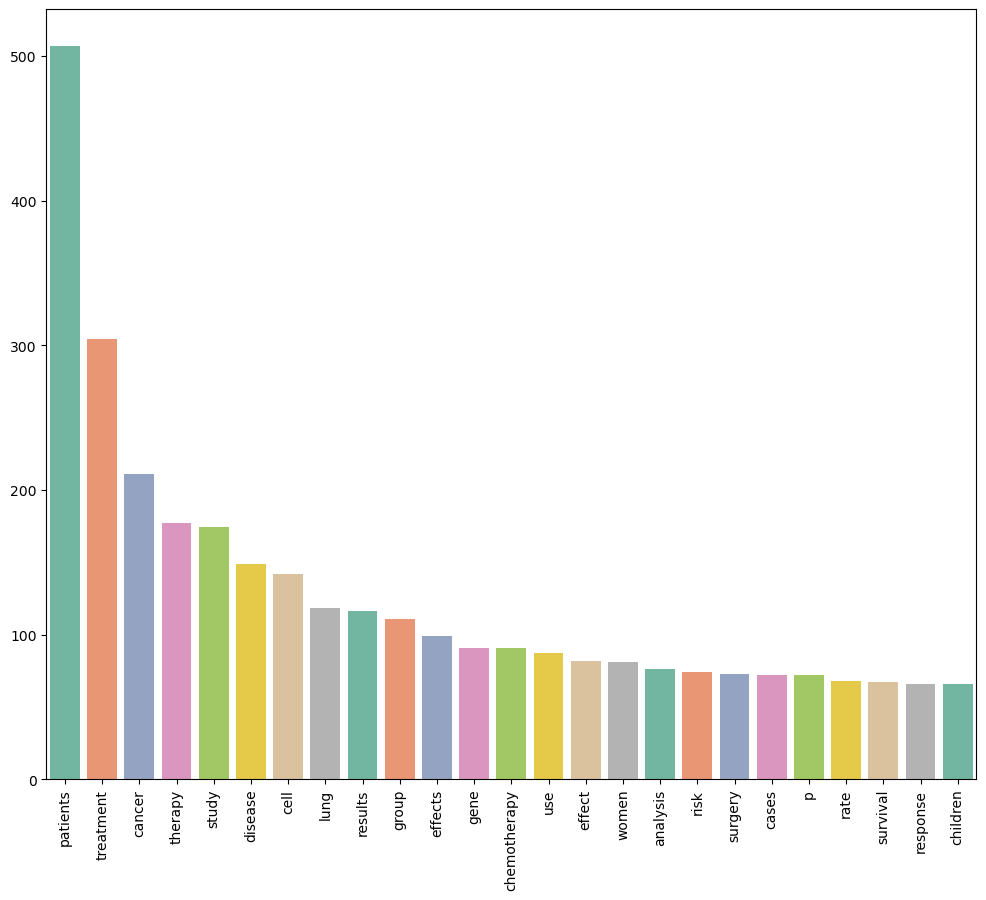

In [32]:
## Visualizing distribution in from of bar graph
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

labels = [element[0] for element in freq.most_common(25)]
counts = [element[1] for element in freq.most_common(25)]
plt.figure(figsize=(12,10))
sns.barplot(x = labels,y= counts, palette='Set2')
plt.xticks(rotation = 90)
plt.show

## Defining features for CRF





In [34]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [37]:
# code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [39]:
# code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

In [42]:
## checking getFeaturesForOneSentence function for single sentence.
example_sentence = train_sent_processed[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[1]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=rates',
 'word[-3:]=tes',
 'word[-2:]=es',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=cesarean',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=True']

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [44]:
## Running getFeaturesForOneSentence function on while sentence train and test data.
X_train = [getFeaturesForOneSentence (sentence) for sentence in train_sent_processed]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent_processed]

### Define the labels as the target variable for test and the train dataset

In [46]:
## Running getLabelsInListForOneSentence function on while sentence train and test label data.
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label_processed]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label_processed]

## Build the CRF Model

In [48]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [51]:
## prediction values.
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [53]:
## Checking F1 score
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9042560946986944

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

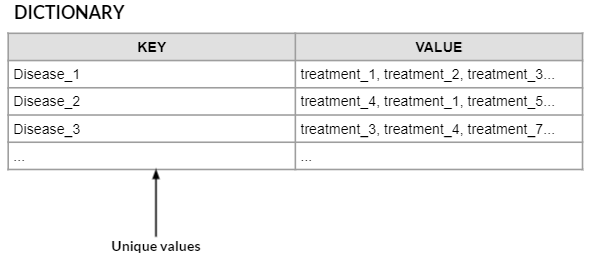

In [57]:
## creating a datafrom with disease and treatment column
import numpy as np
import pandas as pd
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(Y_pred)):
  p_val = Y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent_processed[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent_processed[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,cellulitis,G-CSF therapy intravenous antibiotic treatment
4,foot infection,G-CSF treatment
...,...,...
97,hepatitis B,vaccine
98,temporomandibular joint arthropathy,arthroscopic treatment
99,severe secondary peritonitis,Surgical management
100,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [59]:
## Creating function to get respective treatment for disease.
def prediction(Disease):
    df = dataframe[dataframe['Disease']==Disease]
    print("Treatement for {} is: ".format(Disease),df.Treatments[0])


In [60]:
## Predicting treatment for 'hereditary retinoblastoma'.
Disease = 'hereditary retinoblastoma'
prediction(Disease)

Treatement for hereditary retinoblastoma is:  radiotherapy
